In [1]:
import time
from pathlib import Path
import numpy as np
import os, sys
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from functools import partial

import utils.training as train_utils

from utils.training import adjust_learning_rate, schedule, save_checkpoint
from utils.training import seg_cross_entropy
import augerino.models as models
from augerino.camvid_data import camvid_loaders

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model_cfg = models.FCDenseNet67

In [3]:
loaders, num_classes = camvid_loaders(
    "/home/izmailovpavel/datasets/CamVid/",
    4,
    4,
    ft_batch_size=1,
    transform_train=model_cfg.transform_train,
    transform_test=model_cfg.transform_test,
    joint_transform=model_cfg.joint_transform,
    ft_joint_transform=model_cfg.ft_joint_transform,
    target_transform=model_cfg.target_transform
)

/home/izmailovpavel/datasets/CamVid/


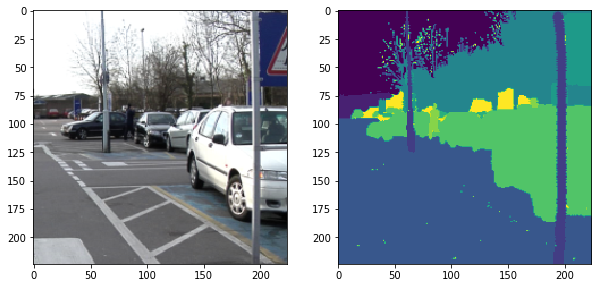

In [4]:
for x, y in loaders['train']:
    break
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())

## Loading the model

In [10]:
model = model_cfg.base(
    *model_cfg.args,
    num_classes=num_classes,
    **model_cfg.kwargs,
    use_aleatoric=False
)
model.cuda();

ckpt = torch.load("ckpts/tiramisu_camvid/run1/checkpoint-860.pt")
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

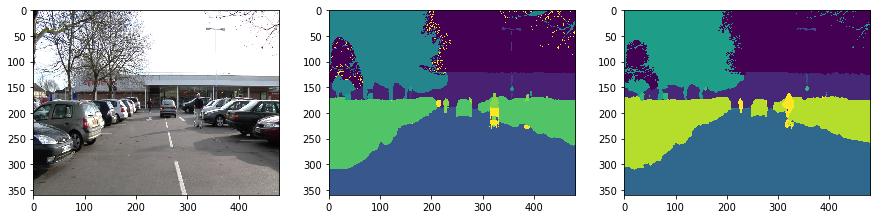

In [11]:
# for x, y in loaders['train']:
#     break
for x, y in loaders['fine_tune']:
    break

    
with torch.no_grad():
    pred = model(x.cuda())
    pred = torch.max(pred, dim=1)[1]
    
f, arr =  plt.subplots(1, 3, figsize=(15, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())
arr[2].imshow(pred[0].detach().cpu().numpy())

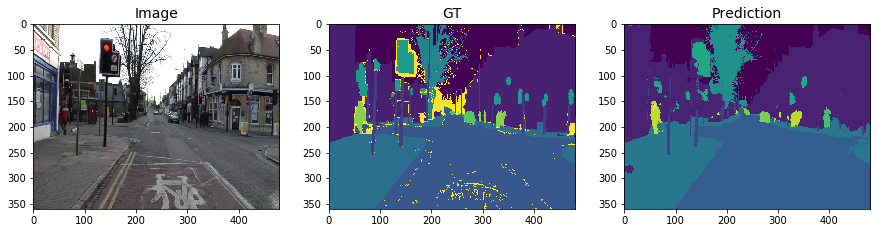

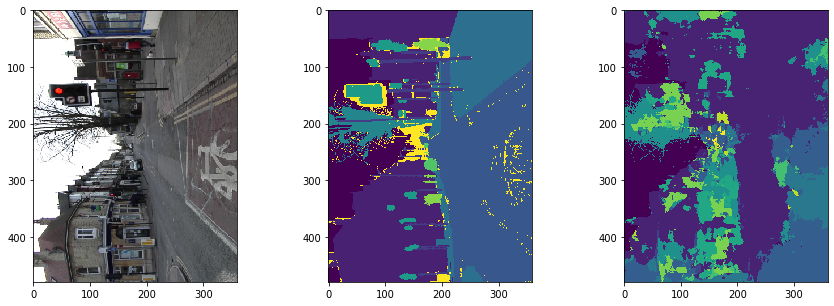

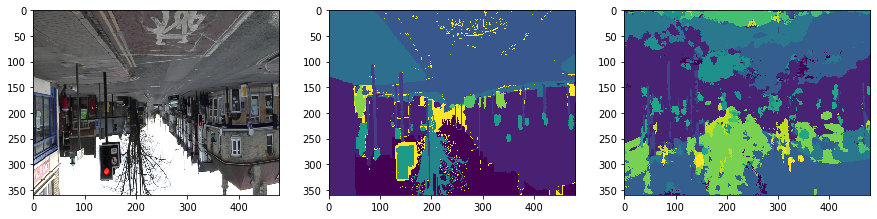

In [12]:
# for x, y in loaders['train']:
#     break
for x, y in loaders['test']:
    break

    
with torch.no_grad():
    pred = model(x.cuda())
    pred = torch.max(pred, dim=1)[1]
    
f, arr =  plt.subplots(1, 3, figsize=(15, 5))
arr[0].set_title("Image", fontsize=14)
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())
arr[1].set_title("GT", fontsize=14)
arr[2].imshow(pred[0].detach().cpu().numpy())
arr[2].set_title("Prediction", fontsize=14)
plt.show()

# Transpose

x = x.permute(0, 1, 3, 2)
y = y.permute(0, 2, 1)

with torch.no_grad():
    pred = model(x.cuda())
    pred = torch.max(pred, dim=1)[1]
    
f, arr =  plt.subplots(1, 3, figsize=(15, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())
arr[2].imshow(pred[0].detach().cpu().numpy())
plt.show()

# Vertical Flip

x = x.permute(0, 1, 3, 2)
y = y.permute(0, 2, 1)
x = x.flip(dims=(-2,))
y = y.flip(dims=(-2,))

with torch.no_grad():
    pred = model(x.cuda())
    pred = torch.max(pred, dim=1)[1]
    
f, arr =  plt.subplots(1, 3, figsize=(15, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())
arr[2].imshow(pred[0].detach().cpu().numpy())
plt.show()

## Augerino Rotations

In [19]:
n_train = len(loaders["train"].dataset)
n_test = len(loaders["test"].dataset)
n_val = len(loaders["val"].dataset)

In [16]:
def get_rotations(num):
    z = torch.randn(num)
    affineMatrices = torch.zeros(num, 2, 3)
    affineMatrices[:,0,0] = z.cos()
    affineMatrices[:,0,1] = -z.sin()
    affineMatrices[:,1,0] = z.sin()
    affineMatrices[:,1,1] = z.cos()
    return affineMatrices

In [17]:
train_rotations = get_rotations(n_train)
torch.save(train_rotations, "train_rotations.pt")

In [46]:
test_rotations = get_rotations(n_test)
torch.save(test_rotations, "test_rotations.pt")

In [20]:
val_rotations = get_rotations(n_val)
torch.save(val_rotations, "val_rotations.pt")

In [31]:
np.savez("rotation_tensors.npz", 
        train=train_rotations.numpy(),
        test=test_rotations.numpy(),
        val=val_rotations.numpy(),
        )

### Loading a dataset

In [5]:
from augerino.rot_camvid_data import RotCamVid, rot_camvid_loaders

%load_ext autoreload
%autoreload 2

In [32]:
arr = np.load("rotation_tensors.npz")
train_rotations = torch.from_numpy(arr["train"]).float()
test_rotations = torch.from_numpy(arr["test"]).float()
val_rotations = torch.from_numpy(arr["val"]).float()

In [33]:
loaders, num_classes = rot_camvid_loaders(
    "/home/izmailovpavel/datasets/CamVid/",
    4,
    4,
    ft_batch_size=1,
    transform_train=model_cfg.transform_train,
    transform_test=model_cfg.transform_test,
    train_rotations=train_rotations,
    test_rotations=test_rotations,
    val_rotations=val_rotations,
    joint_transform=model_cfg.joint_transform,
    ft_joint_transform=model_cfg.ft_joint_transform,
    target_transform=model_cfg.target_transform
)

/home/izmailovpavel/datasets/CamVid/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


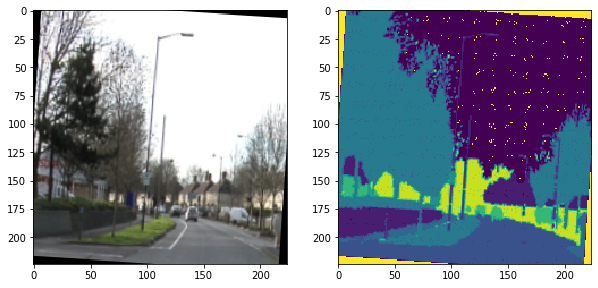

In [34]:
for x, y in loaders['train']:
    break
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())

### For a given image rotation is consistent

Train loader

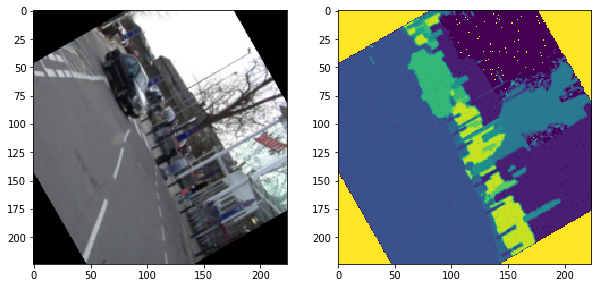

In [35]:
x, y = loaders['train'].dataset[100]
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x.permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y.detach().cpu().numpy())

Fine-Tune loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


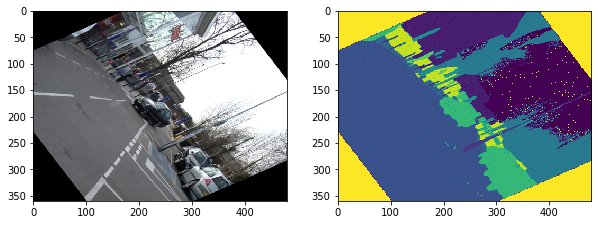

In [36]:
x, y = loaders['fine_tune'].dataset[100]
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x.permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y.detach().cpu().numpy())

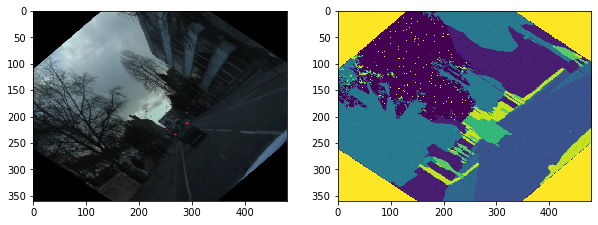

In [37]:
x, y = loaders['test'].dataset[10]
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x.permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y.detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


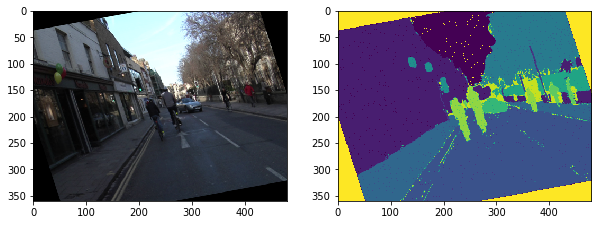

In [38]:
x, y = loaders['val'].dataset[10]
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x.permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y.detach().cpu().numpy())

## Affine Augmentations

In [5]:
from augerino.aug_eq_model import UniformEqAug

In [6]:
aug = UniformEqAug(padding=20)

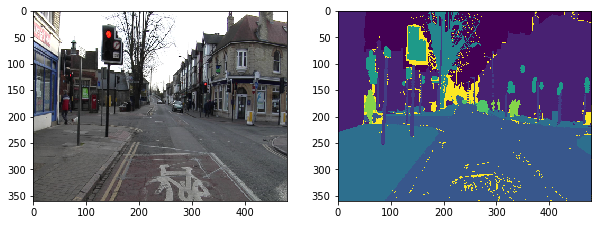

In [7]:
for x, y in loaders['test']:
    break
    
f, arr =  plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(y[0].detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


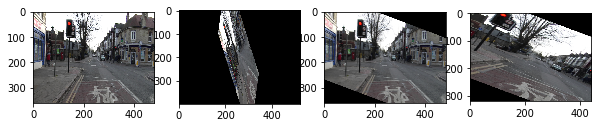

In [8]:
f, arr =  plt.subplots(1, 4, figsize=(10, 5))

arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(aug(x)[0].permute(1,2,0).detach().cpu().numpy())
arr[2].imshow(aug.inverse(aug(x))[0].permute(1,2,0).detach().cpu().numpy())
arr[3].imshow(aug.inverse(x)[0].permute(1,2,0).detach().cpu().numpy())